# HW 4: Nonlinear iterations

9 Points

We put together many of the techniques we have learning about to solve a large 3D nonlinear PDE.

**collaboration statement:**

In [1]:
%pip install scipy numpy matplotlib pyamg
import time
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import minimize
from scipy.sparse import coo_matrix, dia_matrix, kron, eye, csr_matrix, diags, lil_matrix, vstack
from scipy.sparse.linalg import LinearOperator, cg


Note: you may need to restart the kernel to use updated packages.


## A nonlinear PDE problem: the Bratu $p$-Laplacian

In this homework you will build up the components of a solver for the Bratu $p$-Laplacian nonlinear PDE problem.  The problem can be stated the finding of a field $u$ that minimizes an energy:

$$\min_{u, u|_{\partial \Omega} = 0} f(u) := \int_{\Omega} (|\nabla u|^2 + \epsilon)^{p/2} - b u\ dx.$$

When the small parameter $\epsilon$ is 0, $(|\nabla u|^2 + \epsilon)^{p/2} = |\nabla u|^p$, so the energy is associated with the $p$th power of the norm of the gradient of $u$, hence the name.

The solution $u$ satisfies the nonlinear PDE

$$-\nabla \cdot \left\{\underbrace{p(|\nabla u|^2 + \epsilon)^{(p-2)/2}}_{:= \mu(\nabla u)}\nabla u \right\}= b.$$

(If $p= 2$, is the linear Poisson problem).

Below you will find a `BratuProblem` object that can evaluate

- $f(u)$, the objective function,
- $\nabla f(u)$, the gradient of the objective, and
- $\nabla^2 f(u)[v]$, the matrix vector product of the Hessian of the objective with a vector $v$.

The quantity $\nabla^2 f(u)[v]$ looks like the following differential operator applied to $v$:

$$-\nabla \cdot \left\{\mu(\nabla u) \nabla v + \mu'(u)(\nabla v  \cdot \nabla u) \nabla u\right\}.$$

It is easier to compute this Hessian-vector product than it is to build the Hessian matrix.  Instead, if we need to build a matrix for preconditioning, we will build the _Picard_ approximation to the Hessian,

$$-\nabla \cdot \left\{\mu(\nabla u) \nabla v\right\}.$$

The `BratuProblem` will also construct this matrix.

In [2]:
def grid_interp_matrix(d, n):
    B1D = lil_matrix((2*(n+1),n))
    eta = (1.-1./3.**0.5) / 2.
    for i in range(n):
        B1D[2*i + 0,i] = eta
        B1D[2*i + 1,i] = 1. - eta
        B1D[2*i + 2,i] = 1. - eta
        B1D[2*i + 3,i] = eta
    B1D = csr_matrix(B1D)
    B1D.eliminate_zeros()
    B = B1D.copy()
    for i in range(d-1):
        B = csr_matrix(kron(B,B1D))
        B.eliminate_zeros()
    return B

def grid_grad_matrix(d, n):
    """Sparse matrix equivalent to evaluating grid_grad"""
    G1D = lil_matrix((2*(n+1),n))
    h = 1. / (n + 1.)
    for i in range(n):
        G1D[2*i + 0, i] = 1./h
        G1D[2*i + 1, i] = 1./h
        G1D[2*i + 2, i] = -1./h
        G1D[2*i + 3, i] = -1./h
    G1D = csr_matrix(G1D)
    G1D.eliminate_zeros()
    if d == 1:
        return G1D
    G = []
    B1D = grid_interp_matrix(1, n)
    for i in range(d):
        if i == 0:
            Gi = G1D.copy()
        else:
            Gi = B1D.copy()
        for j in range(1,d):
            if j == i:
                Gi = csr_matrix(kron(Gi, G1D))
            else:
                Gi = csr_matrix(kron(Gi, B1D))
            Gi.eliminate_zeros()
        G.append(Gi)
    G = csr_matrix(vstack(G))
    return G

In [3]:
def bratu_rhs(d, n, B):
    """The rhs b for the nonlinear problem"""
    x1D = np.zeros((2*(n+1)))
    eta = (1.-1./3.**0.5) / 2.
    h = 1. / (n+1)
    for i in range(n+1):
        x1D[2*i + 0] = i * h + eta * h
        x1D[2*i + 1] = i * h + (1. - eta) * h
    x1D -= 0.5
    x = np.zeros((d,)+(2*(n+1),)*d)
    for i in range(d):
        x[i] = x1D[(np.newaxis,)*i + (slice(0,2*(n+1)),) + (np.newaxis,)*(d-1-i)]
    x = x.reshape((d,(2*(n+1))**d))
    xdot = np.einsum('ij,ij->j', x, x).reshape((2*(n+1),)*d)
    b = np.array(xdot < d*0.25**2,dtype=x.dtype)
    b = (b - 0.5) * 10
    return (B.T @ b.ravel()).reshape((n,)*d)

In [4]:
def bratu_objective(d, n, p, x, G, B, b=None, eps=1.e-3):
    """Compute the energy for function x"""
    if b is None:
        b = bratu_rhs(d, n, B).reshape(x.shape)
    Gx = (G @ x).reshape((d,(2*(n+1))**d))
    Gdot = np.einsum('ij,ij->j', Gx, Gx)
    sigma = (Gdot + eps)**(p/2.)
    return np.sum(sigma.ravel()) - x.dot(b)

In [5]:
def bratu_gradient(d, n, p, x, G, GT, B, b=None, eps=1.e-3):
    """Compute the gradient of the energy for function x"""
    if b is None:
        b = bratu_rhs(d, n, B).reshape(x.shape)
    Gx = (G @ x).reshape((d,(2*(n+1))**d))
    Gdot = np.einsum('ij,ij->j', Gx, Gx).reshape((2*(n+1),)*d)
    mu = (p/2.)*(Gdot + eps)**((p - 2.)/2.)
    sigma_der = mu[np.newaxis,...]*(2.*Gx.reshape((d,)+(2*(n+1),)*d))
    div_sigma = GT @ sigma_der.ravel()
    return div_sigma - b

In [6]:
def bratu_hessian_vector_product(d, n, p, x, v, G, GT, Gx, mu, mu_der, eps=1.e-3):
    """Compute the Hessian vector product for function x applied to vector v"""
    Gv = (G @ v).reshape((d,(2*(n+1))**d))
    Gvdot = np.einsum('ij,ij->j', Gx, Gv).reshape((2*(n+1),)*d)
    sigma_der = mu[np.newaxis,...]*Gv.reshape((d,)+(2*(n+1),)*d)
    sigma_der += (mu_der*Gvdot)[np.newaxis,...]*Gx.reshape((d,)+(2*(n+1),)*d)
    div_sigma = GT @ sigma_der.ravel()
    return div_sigma

In [7]:
def bratu_picard_hessian_diagonal(d, n, p, x, G, eps=1.e-3):
    """Compute mu(grad x), the coefficient in the Picard approximation to the Hessian"""
    Gx = (G @ x).reshape((d,(2*(n+1))**d))
    Gdot = np.einsum('ij,ij->j', Gx, Gx).reshape((2*(n+1),)*d)
    q = ((p-2.)/2.)
    mu = (p/2.)*(Gdot + eps)**q
    return 2. * mu

In [9]:
class BratuProblem(object):
    def __init__(self, d, n, p, b=None, eps=1.e-3):
        self.B = grid_interp_matrix(d, n)
        self.G = grid_grad_matrix(d, n)
        self.GT = csr_matrix(self.G.T)
        if b is None:
            b = bratu_rhs(d, n, self.B).ravel()
        self.d = d
        self.n = n
        self.p = p
        self.b = b
        self.eps = eps
        self.shape = (b.shape[0], b.shape[0])
        
    def objective(self, x):
        """evaluate the objective"""
        return bratu_objective(self.d, self.n, self.p, x, self.G, self.B, self.b, self.eps)
    
    def gradient(self, x):
        """evaluate the gradient of the objective"""
        return bratu_gradient(self.d, self.n, self.p, x, self.G, self.GT, self.B, self.b, self.eps)
    
    def hessian(self, x):
        """Return a scipy.sparse.linalg.LinearOperator for the Hessian vector product"""
        d = self.d
        n = self.n
        Gx = (self.G @ x).reshape((d,(2*(n+1))**d))
        Gdot = np.einsum('ij,ij->j', Gx, Gx).reshape((2*(n+1),)*d)
        q = ((p-2.)/2.)
        mu = p*(Gdot + eps)**q
        mu_der = (q * mu / (Gdot + eps))*2
        def matvec(y):
            return bratu_hessian_vector_product(self.d, self.n, self.p, x, y, self.G, self.GT, Gx, mu, mu_der, self.eps)
        return LinearOperator(self.shape,matvec=matvec)
    
    def hessian_picard_matrix(self, x):
        """Return a scpy.sparse.csr_matrix for the picard approximation of the Hessian"""
        mu = bratu_picard_hessian_diagonal(self.d, self.n, self.p, x, self.G, self.eps).reshape((2*(self.n+1))**self.d)
        mu = np.kron(np.ones(self.d), mu)
        L = csr_matrix(self.GT @ diags(mu) @ self.G)
        return L  

## A globalized nonlinear solver: Newton-CG linesearch

The Bratu energy is always convex for $p > 1$, so the Hessian $H(u) = \nabla^2 f(u)$ is always positive definite.
Therefore the Newton update direction is always a descent direction, so a Newton iteration globalized by a linesearch will converge to the solution.  An implementation of Newton-CG linesearch is below.

The function returns the solution $x$, as well as the residual history.  Two residuals are computed at each _CG iteration_.  When using CG to solve

$$\nabla^2 f(x_k) p = - \nabla f(x_k),$$

it records the linear residual,

$$\|\nabla^2 f(x_k) p + \nabla f(x_k)\|,$$

as well as the magnitude of the gradient at the potential new point $x_k + p$,

$$\|\nabla f(x_k + p)\|.$$

When these two values are similar, it means that the quadratric approximation

$$m(x) = f(x_k) + \nabla f(x_k) \cdot (x - x_k) + \tfrac{1}{2} (x - x_k)^T \nabla^2 f(x_k) (x - x_k),$$

is a good approximation for $f(x)$.  When they are different, it means that solving the Newton update with high accuracy is not very useful.  Each residual evaluation also comes with a timestamp, so that we can track convergence in terms of runtime, not iteration.

In [10]:
def newton_cg(f, f_der, f_hess, x0,
              cg_tol_0=1.e-3, cgupdate=None,
              f_hess_prec=None, f_hess_prec_update=None,
              tol=1.e-6, xtol=1.e-10, maxit=100, armijo_alpha=1.e-4, lamda_min=1.e-12):
    """Minimize f(x) from initial guess x0
    
    f: function to minize
    f_def: gradient of f, returns a vector
    f_hess: Hessian of f, returns a matrix or LinearOperator
    x0: initial guess
    
    cg_tol_0: the relative tolerance to use when solving the first Newton update problem
    cgupdate: function that determines what tolerance to use for CG iterations after the first, cg_tol_0 is used
              if cgupdate is None. The input arguments to cgupdate are:
                  gxnorm: the norm of $grad f$ for the current value of x
                  prevgxnorm: the norm of $grad f$ for the previous value of x
                  prev_linear_rnorm: the residual norm from the previous Newton update problem
              
    f_hess_prec: the initial preconditioner to use for the first Newton updateproblem
    f_hess_prec_update: function that computes a new preconditioner for each Newton update after the first.
                        the initial preconditioner is used if f_hess_prec_update is None.  The input
                        arguments to f_hess_prec_update are:
                            x: the current solution vector x
                            Mx_prev: the preconditioner from the previous iteration
                            y: the difference (grad f(x) - grad f(x_prev))
                            s: the difference (x - x_prev)
                            
    tol: the tolerance for |grad f(x)| to end the iteration
    xtol: the tolerance for p.dot(grad fx) to end the iteration, where p is the Newton search direction
    maxit: the maximum number of iterations
    
    armijo_alpha: the tolerance for the first armijo line search condition
    lambda_min: the minimum line search distance before the line search terminates
    """
    x = x0.copy()
    residuals_and_times = []
    gxnorm = 0.
    M0 = f_hess_prec
    gx = None
    for i in range(maxit):
        # compute the objective and gradient
        fx = f(x)
        gx_prev = gx
        gx = f_der(x)
        if i > 0:
            y = gx - gx_prev
        
        # store the previous gradient norm and compute the new one
        prevgxnorm = gxnorm
        gxnorm = np.linalg.norm(gx)
        
        # stop if the gradient is small enough
        if (gxnorm < tol):
            print("iter", i, "gradient norm", gxnorm)
            break
            
        # "Compute" the Hessian (create the Hessian-vector product object)
        Hx = f_hess(x)
        
        # callback to store the residual of the linear problem and the nonlinear problem at each  CG iteration
        cgit = [0]
        def cg_callback(xk):
            linear_residual = np.linalg.norm(Hx @ xk + gx)
            nonlinear_residual = np.linalg.norm(f_der(x + xk))
            cgit[0] += 1
            residuals_and_times.append([time.time(), linear_residual, nonlinear_residual])
            
        # Compute the preconditioner
        if i == 0:
            Mx = M0
        elif f_hess_prec_update is not None:
            Mx_prev = Mx
            Mx = f_hess_prec_update(x, Mx_prev, y, s)
            
        # Determine the tolerance for CG
        if i == 0 or cgupdate is None:
            cg_tol = cg_tol_0
        else:
            cg_tol = cgupdate(gxnorm, prevgxnorm, prev_linear_rnorm, tol)
            
        # Compute the Newton update direction
        sol = cg(Hx, -gx, M=Mx, callback=cg_callback, atol=0., tol=cg_tol)
        p = sol[0]

        lamda = 1. 
        pgx = p.dot(gx)
        if (np.abs(pgx) < xtol):
            print("iter", i, "cg iterations", cgit[0], "gradient norm", gxnorm, "step norm", pgx)
            break
        while lamda > lamda_min:
            xnew = x + lamda * p
            fxnew = f(xnew)
            diff = fxnew - fx
            if diff < armijo_alpha * pgx:
                break
            lamda = lamda / 2.
        if (lamda <= lamda_min):
            break
        prev_linear_rnorm = np.linalg.norm(lamda * Hx @ p + gx)
        print("iter", i, "cg iterations", cgit[0], "gradient norm", gxnorm, "step norm", pgx, "line search length", lamda)
        s = xnew - x
        x = xnew
    return x, residuals_and_times
        

Here is an example of using the `newton_cg` solver on the Bratu problem in 2D for different problem sizes:

------ n = 3 ------
iter 0 cg iterations 4 gradient norm 114.41732405090154 step norm -0.4372746701296552 line search length 1.0
iter 1 cg iterations 4 gradient norm 93.29267195645491 step norm -1.5363277765640466 line search length 1.0
iter 2 cg iterations 4 gradient norm 64.99008154612712 step norm -1.722808109534241 line search length 1.0
iter 3 cg iterations 4 gradient norm 39.140973524793885 step norm -0.9509711578466665 line search length 1.0
iter 4 cg iterations 4 gradient norm 21.590412691660024 step norm -0.357095736703065 line search length 1.0
iter 5 cg iterations 4 gradient norm 11.35327461579637 step norm -0.10970993349461193 line search length 1.0
iter 6 cg iterations 4 gradient norm 5.823358448350743 step norm -0.030425820599446235 line search length 1.0
iter 7 cg iterations 4 gradient norm 2.949288340872853 step norm -0.008012782039234471 line search length 1.0
iter 8 cg iterations 4 gradient norm 1.4841608336479686 step norm -0.0020560840714677554 line search length 1.

iter 2 cg iterations 48 gradient norm 3939.713881741255 step norm -1529.7374956058693 line search length 1.0
iter 3 cg iterations 55 gradient norm 2410.974084717545 step norm -901.3714700647239 line search length 1.0
iter 4 cg iterations 61 gradient norm 1341.9912497291325 step norm -350.7749061938019 line search length 1.0
iter 5 cg iterations 62 gradient norm 708.8006112492988 step norm -109.79012438694319 line search length 1.0
iter 6 cg iterations 63 gradient norm 364.2217170600546 step norm -30.736913594389748 line search length 1.0
iter 7 cg iterations 63 gradient norm 184.5517505436611 step norm -8.133055491102636 line search length 1.0
iter 8 cg iterations 64 gradient norm 92.85574558971761 step norm -2.091826314040891 line search length 1.0
iter 9 cg iterations 64 gradient norm 46.55559725433374 step norm -0.5304202211012018 line search length 1.0
iter 10 cg iterations 63 gradient norm 23.301399342943288 step norm -0.13354335189787575 line search length 1.0
iter 11 cg iteratio

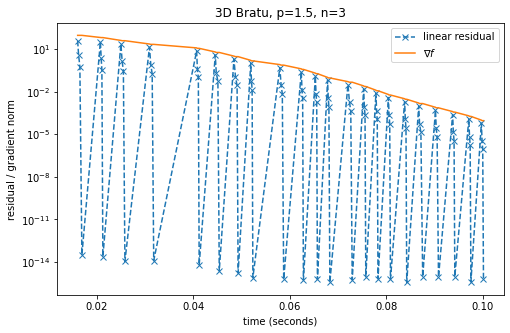

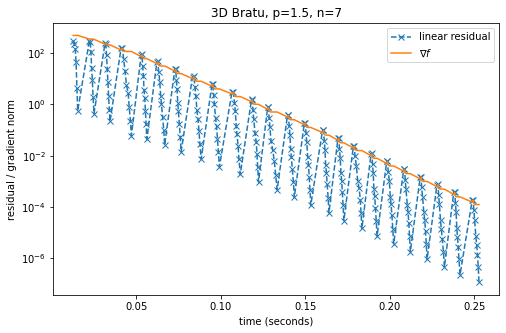

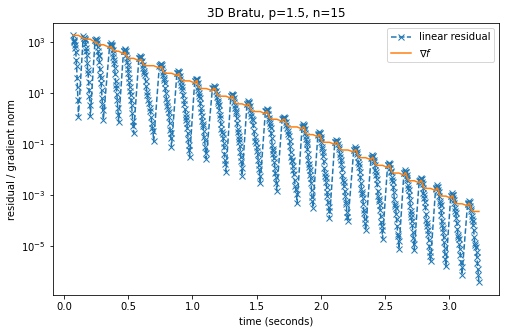

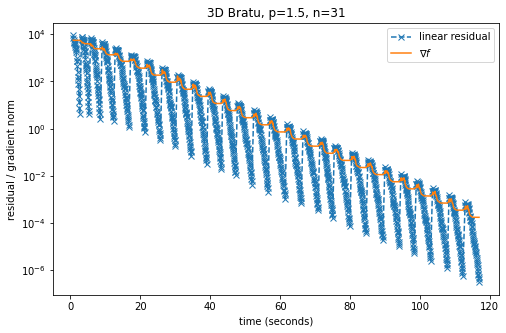

In [11]:
d = 3
p = 1.5
eps=1.e-8

for n in [3, 7, 15, 31,]:
    print('------ n = {} ------'.format(n))
    t0 = time.time()
    prob = BratuProblem(d, n, p, eps=eps)
    x0 = np.zeros(prob.shape[0])
    x, res = newton_cg(prob.objective, prob.gradient, prob.hessian_picard_matrix, x0)
    res = np.array(res)
    ax = plt.figure(figsize=(8,5)).gca()
    ax.set(title="{}D Bratu, p={}, n={}".format(d,p,n), xlabel='time (seconds)', ylabel=r'residual / gradient norm')
    ax.semilogy(res[:,0]-t0,res[:,1], 'x--', label="linear residual")
    ax.semilogy(res[:,0]-t0,res[:,2], label=r'$\nabla f$')
    ax.legend()

------ n = 3 ------
iter 0 cg iterations 4 gradient norm 114.41732405090154 step norm -0.4372746701296551 line search length 1.0
iter 1 cg iterations 3 gradient norm 93.29267195645492 step norm -3.057563731927597 line search length 1.0
iter 2 cg iterations 3 gradient norm 48.284285626508684 step norm -2.5139747185166303 line search length 1.0
iter 3 cg iterations 4 gradient norm 10.746203491527515 step norm -0.18937232190714198 line search length 1.0
iter 4 cg iterations 4 gradient norm 0.5144131562973921 step norm -0.0004488630037568757 line search length 1.0
iter 5 cg iterations 4 gradient norm 0.0012074504485089712 step norm -2.1974349380615932e-09 line search length 1.0
iter 6 gradient norm 6.825862231491843e-09
------ n = 7 ------
iter 0 cg iterations 6 gradient norm 592.904711135541 step norm -4.335203717180909 line search length 1.0
iter 1 cg iterations 8 gradient norm 483.8665097834735 step norm -34.192391222604286 line search length 1.0
iter 2 cg iterations 9 gradient norm 254

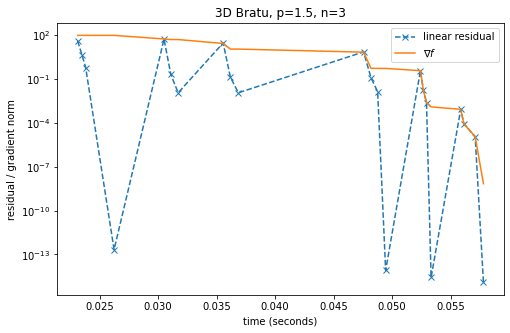

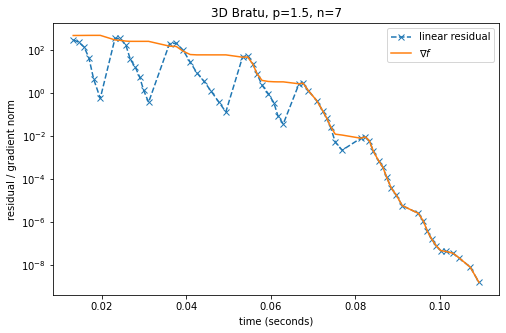

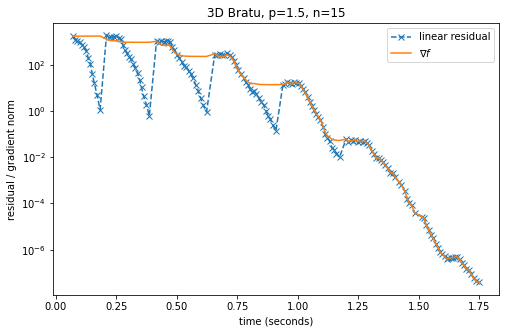

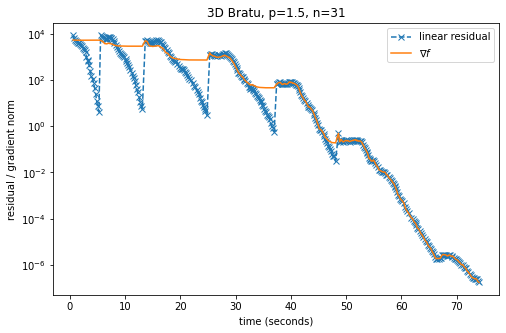

In [11]:
d = 3
p = 1.5
eps=1.e-8

for n in [3, 7, 15, 31,]:
    print('------ n = {} ------'.format(n))
    t0 = time.time()
    prob = BratuProblem(d, n, p, eps=eps)
    x0 = np.zeros(prob.shape[0])
    x, res = newton_cg(prob.objective, prob.gradient, prob.hessian, x0)
    res = np.array(res)
    ax = plt.figure(figsize=(8,5)).gca()
    ax.set(title="{}D Bratu, p={}, n={}".format(d,p,n), xlabel='time (seconds)', ylabel=r'residual / gradient norm')
    ax.semilogy(res[:,0]-t0,res[:,1], 'x--', label="linear residual")
    ax.semilogy(res[:,0]-t0,res[:,2], label=r'$\nabla f$')
    ax.legend()

------ n = 3 ------
iter 0 cg iterations 4 gradient norm 114.41732405090154 step norm -0.4372746701296551 line search length 1.0
iter 1 cg iterations 3 gradient norm 93.29267195645492 step norm -3.057563731927597 line search length 1.0
iter 2 cg iterations 3 gradient norm 48.284285626508684 step norm -2.5139747185166303 line search length 1.0
iter 3 cg iterations 4 gradient norm 10.746203491527515 step norm -0.18937232190714198 line search length 1.0
iter 4 cg iterations 4 gradient norm 0.5144131562973921 step norm -0.0004488630037568757 line search length 1.0
iter 5 cg iterations 4 gradient norm 0.0012074504485089712 step norm -2.1974349380615932e-09 line search length 1.0
iter 6 gradient norm 6.825862231491843e-09
------ n = 7 ------
iter 0 cg iterations 6 gradient norm 592.904711135541 step norm -4.335203717180909 line search length 1.0
iter 1 cg iterations 8 gradient norm 483.8665097834735 step norm -34.192391222604286 line search length 1.0
iter 2 cg iterations 9 gradient norm 254

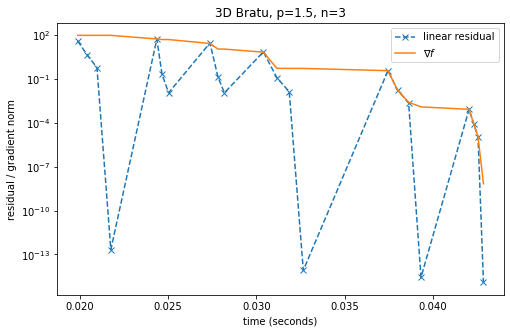

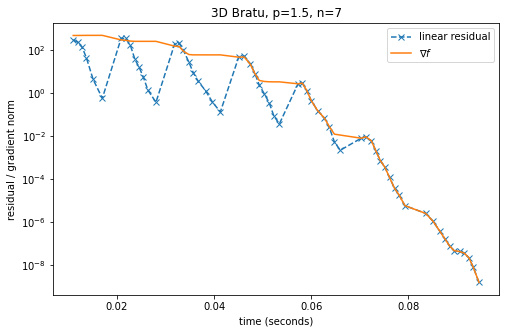

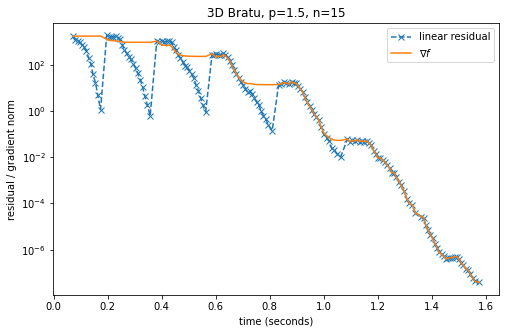

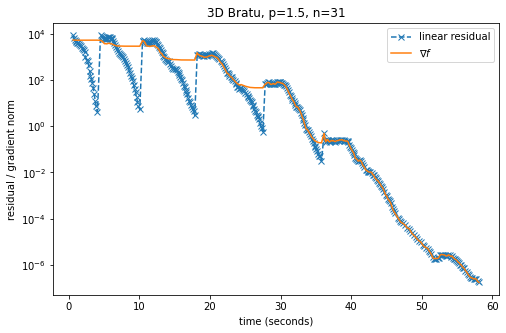

In [10]:
d = 3
p = 1.5
eps=1.e-8

for n in [3, 7, 15, 31,]:
    print('------ n = {} ------'.format(n))
    t0 = time.time()
    prob = BratuProblem(d, n, p, eps=eps)
    x0 = np.zeros(prob.shape[0])
    x, res = newton_cg(prob.objective, prob.gradient, prob.hessian, x0)
    res = np.array(res)
    ax = plt.figure(figsize=(8,5)).gca()
    ax.set(title="{}D Bratu, p={}, n={}".format(d,p,n), xlabel='time (seconds)', ylabel=r'residual / gradient norm')
    ax.semilogy(res[:,0]-t0,res[:,1], 'x--', label="linear residual")
    ax.semilogy(res[:,0]-t0,res[:,2], label=r'$\nabla f$')
    ax.legend()

**Question 1 (2 points):** Looking at the convergence plots, we see that in solving the linear equations that CG takes a lot more iterations to converge as $n$ increases.  This is because CG is not preconditioned right now.  The Hessian is like a variable coefficient Laplacian, so a multilevel preconditioner (like multigrid or multilevel domain decomposition) could get us close to $h$-independent convergence.

Rather than writing your own multilevel preconditioner, use the [pyamg](pyamg.readthedocs.io) library to construct a preconditioner for $\nabla^2 f(x)$ from the matrix of the Picard approximation.

_Hint:_ Take a look at [this demo](https://github.com/pyamg/pyamg-examples/blob/master/Preconditioning/demo.py) to see how a preconditioner can be constructed using `pyamg`.

_Hint 2:_ `pyamg` provides two relevant algebraic multigrid preconditioners, one "classical Ruge-Stuben" and one "smoothed aggregation".  Try them both and use the one that gives you the best runtimes for this problem.

In [ ]:
def bratu_picard_preconditioner(bratu_prob, x):
    """
    Args:
        bratu_prob (BratuProblem): driver for the nonlinear equations
        x (np.ndarray): the current solution
    Returns:
        scipy.sparse.linalg.LinearOperator: a multigrid preconditioner based on the Picard approximation to
        the Hessian"""
    # YOUR CODE HERE
    raise NotImplementedError()

We now use your preconditioner in `newton_cg`.

In [ ]:
d = 3
p = 1.5
eps=1.e-8

for n in [3, 7, 15, 31,]:
    print('------ n = {} ------'.format(n))
    t0 = time.time()
    prob = BratuProblem(d, n, p, eps=eps)
    def preconditioner_update_picard(x, Mprev, y, s):
        return bratu_picard_preconditioner(prob, x)
    x0 = np.zeros(prob.shape[0])
    M0 = bratu_picard_preconditioner(prob, x0)
    x, res = newton_cg(prob.objective, prob.gradient, prob.hessian, x0, f_hess_prec=M0,
                       f_hess_prec_update=preconditioner_update_picard)
    res = np.array(res)
    ax = plt.figure(figsize=(8,5)).gca()
    ax.set(title="{}D Bratu, p={}, n={}".format(d,p,n), xlabel='time (seconds)', ylabel=r'residual / gradient norm')
    ax.semilogy(res[:,0]-t0,res[:,1], 'x--', label="linear residual")
    ax.semilogy(res[:,0]-t0,res[:,2], label=r'$\nabla f$')
    ax.legend()

**Question 2 (2 points):** We see that the magnitude of the gradient (orange) diverges from the linear residual (blue).  This means that we are oversolving the Newton updates, and we should use a coarser tolerance.  Use the Eisenstat-Walker method (equation 2.2 in the the paper in the course notes) to choose the relative tolerance based on:

- `current_nonlin_res`: $\|\nabla f(x_k)\|$
- `prev_nonlin_res`: $\|\nabla f(x_{k-1})\|$
- `prev_linl_res`: $\|\nabla^2 f(x_{k-1})(x_k - x_{k-1}) + \nabla f(x_{k-1})\|$
- `target_nonlin_res`: The desired tolerance for $\|\nabla f(x_{k+1})\|$

In [ ]:
def cgupdate_eisenstat_walker(curr_nonlin_res, prev_nonlin_res, prev_lin_res, target_nonlin_res):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
d = 3
p = 1.5
eps=1.e-8

for n in [3, 7, 15, 31,]:
    print('------ n = {} ------'.format(n))
    t0 = time.time()
    prob = BratuProblem(d, n, p, eps=eps)
    def preconditioner_update_picard(x, Mprev, y, s):
        return bratu_picard_preconditioner(prob, x)
    x0 = np.zeros(prob.shape[0])
    M0 = bratu_picard_preconditioner(prob, x0)
    x, res = newton_cg(prob.objective, prob.gradient, prob.hessian, x0, f_hess_prec=M0,
                       f_hess_prec_update=preconditioner_update_picard,
                       cgupdate=cgupdate_eisenstat_walker)
    res = np.array(res)
    ax = plt.figure(figsize=(8,5)).gca()
    ax.set(title="2D Bratu, p={}, n={}".format(d,n), xlabel='time (seconds)', ylabel=r'residual / gradient norm')
    ax.semilogy(res[:,0]-t0,res[:,1], 'x--', label="linear residual")
    ax.semilogy(res[:,0]-t0,res[:,2], label=r'$\nabla f$')
    ax.legend()

**Question 3 (2 points):** Recomputing the preconditioner gives us good convergence rates for each CG solve, but it takes time.  One thing we would like to be able to do is reuse the preconditioner from a previous iteration.

A way to take a preconditioner from a previous iteration and make t more accurate for the current Newton update problem is to use a secant method.  So if I have a preconditioner $M_k \approx (\nabla f^2 (x_k))$, I can perform the BFGS update

$$M_{k+1} = M_k + \frac{y y^T}{y^T s} - \frac{M_k s s^T M_k}{s^T M_k s},$$

where $s = x_{k+1} - x_{k}$ and $y = \nabla f(x_{k+1}) - \nabla f(x)$.

Below, the class `BFGSUpdate` takes in a precontioner `Mprev` that is a `scipy.sparse.linalg.LinearOperator` for the previous preconditioner, the current solution `x`, and the vectors `y` and `s` and will store information necessary to apply the inverse of the BFGS update of `Mprev`.  The class will also recompute the preconditioner from scratch every `maxlevel` iterations.

The values of $M_{k}^{-1} y$, $y^T s$, $d = s - M_{k}^{-1} y$ and $d^T y$ are stored for you.  Use them to compute
$M_{k+1}^{-1} v$.

_Hint:_ use the formula for the inverse of a rank-2 update from Dennis & Schnabel, chapter 9.

In [ ]:
class BFGSUpdate(LinearOperator):
    def __init__(self, x, Mprev, y, s, maxlevel=2, recompute=None):
        super(BFGSUpdate, self).__init__(shape=Mprev.shape, dtype=Mprev.dtype)
        if isinstance(Mprev, BFGSUpdate):
            self._bfgslevel = Mprev._bfgslevel + 1
        else:
            self._bfgslevel = 0
        if self._bfgslevel == maxlevel and recompute:
            Mprev = recompute(x, None, None, None)
            self._bfgslevel = -1
            y = np.zeros(y.shape)
            s = np.zeros(s.shape)
            
        # Here are the stored values that you will need in computing the matvec
        self.Mprev = Mprev
        self.Mprevy = Mprev @ y
        self.ys = y.dot(s)
        assert(self.ys >= 0.)
        self.s = s
        self.y = y
        self.d = s - self.Mprevy
        self.dy = self.d.dot(self.y)

        
    def _matvec(self, v):
        if self._bfgslevel == -1:
            return self.Mprev @ v
        """Apply the BFGS update to Mprev to the vector here"""
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
# Test BFGS: create an s.p.d. matrix, and verify that if the inverse is applied to y, it yields s
A = np.random.randn(10,10)
B = A @ A.T
Binv = np.linalg.inv(B)
s = np.random.randn(10)
y = np.random.randn(10)
x = np.random.randn(10)
if (y.dot(s) < 0):
    y = -y
    
bfgs = BFGSUpdate(x, Binv, y, s)

z = bfgs @ y
assert(np.linalg.norm(z - s) < 1.e-8)

Your BFGS updated preconditioner is used below.  Adjust the `maxlevel` parameter to find the value that
minimizes the solution time.

In [ ]:
maxlevel = 0
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
d = 3
p = 1.5
eps=1.e-8


for n in [3, 7, 15, 31, 63]:
    print('------ n = {} ------'.format(n))
    t0 = time.time()
    prob = BratuProblem(d, n, p, eps=eps)
    def preconditioner_update_picard(x, Mprev, y, s):
        return bratu_picard_preconditioner(prob, x)
    x0 = np.zeros(prob.shape[0])
    M0 = bratu_picard_preconditioner(prob, x0)
    bfgs = lambda x, Mprev, y, s: BFGSUpdate(x, Mprev, y, s, maxlevel=maxlevel,
                                             recompute=preconditioner_update_picard)
    x, res = newton_cg(prob.objective, prob.gradient, prob.hessian, x0, f_hess_prec=M0,
                       f_hess_prec_update=bfgs,
                       cgupdate=cgupdate_eisenstat_walker)
    res = np.array(res)
    ax = plt.figure(figsize=(8,5)).gca()
    ax.set(title="{}D Bratu, p={}, n={}".format(d,p,n), xlabel='time (seconds)', ylabel=r'residual / gradient norm')
    ax.semilogy(res[:,0]-t0,res[:,1], 'x--', label="linear residual")
    ax.semilogy(res[:,0]-t0,res[:,2], label=r'$\nabla f$')
    ax.legend()

**Question 4 (3 points):** As you can see in the last plot for $n=63$, a lot of time is still spent in the regime before superlinear convergence is observed.  To avoid this, we would need a better initial guess than $x_0 = 0$.

We can get a better initial guess by using the solution from a coarser mesh that has been prolonged to the current mesh.  This multigrid-like approach to nonlinear problems is called _grid continuation_.  Define a prolongation operator that extends a coarse grid with grid spacing $H$ to a fine grid with $h=H/2$.

_Hint 1:_ You could use the prolongation operator from activity 3.3, but the prolongation of the coarse solution will be closer to the true solution if a higher-order operator is used.  You may want to use a prolongation based on the 1D stencil:

$$p = ] 1/8 \ 1/2 \ 3/4 \ 1/2 \ 1/8 [.$$

In [ ]:
def prolongation(d, n_H, x_H):
    """
    Args:
        d (int): the dimension
        n_H (int): the number of gridpoints per direction
        x_H (ndarray): a d-dimension array with n points in each direction
    Returns:
        ndarray: the prolongation of x_H to x_h, a grid with n_h = 2*n_H + 1 points per direction"""
    # YOUR CODE HERE
    raise NotImplementedError()

Now we put together all of these ideas into a nonlinear solver for a large 3D problem.  Choose parameters to solve the case $n=63$ as quickly as possible.

In [ ]:
cg_tol_0 = 1.e-3
maxlevel = 0
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
d = 3
p = 1.5
eps=1.e-8

x = None
ax = plt.figure(figsize=(13,8)).gca()
ax.set(title="{}D Bratu, p={}".format(d,p), xlabel='time (seconds)', ylabel=r'residual / gradient norm')
t0 = time.time()
for n in [3, 7, 15, 31, 63]:
    print('------ n = {} ------'.format(n))
    prob = BratuProblem(d, n, p, eps=eps)
    def preconditioner_update_picard(x, Mprev, y, s):
        return bratu_picard_preconditioner(prob, x)
    if x is not None:
        x0 = prolongation(d, (n-1)//2, x).ravel()
    else:
        x0 = np.zeros(prob.b.shape)
    M0 = bratu_picard_preconditioner(prob, x0)
    bfgs = lambda x, Mprev, y, s: BFGSUpdate(x, Mprev, y, s, maxlevel=maxlevel,
                                             recompute=preconditioner_update_picard)
    x, res = newton_cg(prob.objective, prob.gradient, prob.hessian, x0, f_hess_prec=M0,
                       f_hess_prec_update=bfgs,
                       cg_tol_0=cg_tol_0,
                       cgupdate=cgupdate_eisenstat_walker)
    res = np.array(res)
    ax.semilogy(res[:,0]-t0,res[:,1], 'x--', label="linear residual, n={}".format(n))
    ax.semilogy(res[:,0]-t0,res[:,2], label=r'nonlin residual, n={}'.format(n))
_ = ax.legend()